In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.regression import PearsonCorrCoef

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import wandb
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from itertools import combinations

In [40]:
spectra_df = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

# Plotting Function Definitions:
---

In [41]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [42]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,5], window=300, cutoff = 0.5):
  """
  Plot and compare real and synthetic spectra within a specified index range.

  Takes in real, noisy, and synthetic spectra and plots them for comparison.
  Computes and prints the weighted cosine similarity between the real spectrum and 
  both the noisy and synthetic spectra.

  Args:
      real_spectra (list of list of float): List of real spectra, where each spectrum is a list of intensity values.
      fake_spectra (list of list of float): List of synthetic spectra generated by decoder.
      labels (list of str): List of chemical name labels corresponding to each spectrum.
      idx (list of int, optional): Range of indices to plot. Default is [0, 10].
      window (int, optional): Highest m/z to plot for each spectrum. Default is 300.
      cutoff (float, optional): Intensity cutoff threshold to filter out low-intensity noise. Default is 0.5.
  """
  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plot spectra within the specified index range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:
      # Define the x-axis range
      numbers = range(0, window)
      
      # Scale the real spectrum so highest peak is 100
      input_frequencies = real_spec.copy()
      input_max = max(input_frequencies)
      scaled_input = [num/input_max * 100 for num in input_frequencies]

      # Scale the synthetic spectrum so highest peak is 100
      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      # Create a plot with 2 subplots for real and synthetic spectra
      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_input[:window])
      ax[0].set_title(f'True {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity between true spectrum and output spectrum is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

# Model Definition:
---

VAE based on model from this paper: https://ieeexplore.ieee.org/abstract/document/10463452

Using this tutorial for help: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [43]:
class VAE(nn.Module):
  """
    Variational Autoencoder (VAE) class implementation.

    The VAE consists of an encoder that maps input data to a latent space
    and a decoder that reconstructs the data from the latent space. The latent
    space is characterized by a mean and log variance, which are used to sample
    latent vectors.

    Attributes:
        encoder (nn.Sequential): Neural network to encode input data into a latent space.
        mean_layer (nn.Linear): Linear layer to compute the mean of the latent space.
        logvar_layer (nn.Linear): Linear layer to compute the log variance of the latent space.
        decoder (nn.Sequential): Neural network to decode latent vectors back into the data space.
  """
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Linear(915,819),
      nn.LeakyReLU(),
      nn.Linear(819, 723),
      nn.LeakyReLU(),
      nn.Linear(723, 627),
      nn.LeakyReLU(),
      nn.Linear(627,531),
      nn.LeakyReLU(),
      nn.Linear(531,435),
      nn.LeakyReLU(),
      nn.Linear(435,339),
      nn.LeakyReLU(),
      nn.Linear(339,243),
      nn.LeakyReLU(),
      nn.Linear(243,147),
      nn.LeakyReLU(),
      nn.Linear(147,100),
    )

    self.mean_layer = nn.Linear(100, 2)
    self.logvar_layer = nn.Linear(100, 2)

    self.decoder = nn.Sequential(
      nn.Linear(2,98),
      nn.LeakyReLU(),
      nn.Linear(98,194),
      nn.LeakyReLU(),
      nn.Linear(194,290),
      nn.LeakyReLU(),
      nn.Linear(290,386),
      nn.LeakyReLU(),
      nn.Linear(386,482),
      nn.LeakyReLU(),
      nn.Linear(482,578),
      nn.LeakyReLU(),
      nn.Linear(578,674),
      nn.LeakyReLU(),
      nn.Linear(674,770),
      nn.LeakyReLU(),
      nn.Linear(770,866),
      nn.LeakyReLU(),
      nn.Linear(866,915),
    )
  
  def encode(self, x):
    x = self.encoder(x)
    mean, logvar = self.mean_layer(x), self.logvar_layer(x)
    return mean, logvar

  def reparameterization(self, mean, log_var):
    eps = torch.randn_like(log_var)
    z = mean + log_var * eps
    return z
  
  def decode(self, z):
    return self.decoder(z)
  
  def forward(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterization(mean, logvar)
    x_hat = self.decode(z)
    return x_hat, mean, logvar

# Generate Dataset:
---

In [44]:
# def generate_dataset(true_spec_data, spectra_names, test_chem = 'Succinic Acid', test_condition=8):
#     true_spectra_train = []
#     train_name_encodings = []

#     true_spectra_test = []
#     test_name_encodings = []

#     spectra_copy = true_spec_data.copy()

#     for spec, label in zip(spectra_copy, spectra_names):
#         # default is to use same test data as in spider model, Succinic Acid on GC-EI-TOF
#         if label == test_chem:
#             if list(spec[-12:]).index(1) == test_condition:
#                 true_spectra_test.append(spec[:915])
#                 test_name_encodings.append(spec[915:965])
#         else:
#             true_spectra_train.append(spec[:915])
#             train_name_encodings.append(spec[915:965])

#     true_spectra_train_tensor = torch.tensor(true_spectra_train, dtype=torch.float32)
#     train_dataset = TensorDataset(true_spectra_train_tensor, torch.tensor(train_name_encodings))
#     train_dataset = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

#     true_spectra_test_tensor = torch.tensor(true_spectra_test, dtype=torch.float32)
#     test_dataset = TensorDataset(true_spectra_test_tensor, torch.tensor(test_name_encodings))
#     test_dataset = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

#     return train_dataset, test_dataset

In [45]:
# chemical name encodings are currently stored between indices 915 and 965 in each data point
chemical_encodings = torch.tensor(spectra_df[:][915:965].T.values, dtype=torch.float)
# # removing name embeddings and condition information and truncating spectra to 650 ----------- NOT TRUNCATING CURRENTLY
data = torch.tensor(spectra_df[:][:915].T.values, dtype=torch.float)
x_train, x_test, train_chem_encodings, test_chem_encodings = train_test_split(data, chemical_encodings, test_size=.2, random_state = 42)

sorted_chem_names = sorted(list(set(chem.split('.')[0] for chem in spectra_df.columns)))

batch_size = 32
train_dataset = DataLoader(TensorDataset(x_train, train_chem_encodings), batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(TensorDataset(x_test, test_chem_encodings), batch_size=batch_size, shuffle=True)

# Train Model:
---

In [46]:
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'mass_spec',
    'gpu':True,
    'threads':1,
}

# Set WANDB_NOTEBOOK_NAME environment variable
os.environ['WANDB_NOTEBOOK_NAME'] = 'variational_autoencoder.ipynb'

In [47]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [48]:
# # create list of chemical names
spectra_names = [chem.split('.')[0] for chem in spectra_df.columns]

# # separate spectrum data from chemical name encodings
# true_spec_data = spectra.values.T 
# encoded_names = torch.tensor(spectra[:][915:965].values, dtype=torch.float32).T

# train_dataset, test_dataset = generate_dataset(true_spec_data, spectra_names)

Pytorch implementation from: https://discuss.pytorch.org/t/elbo-loss-in-pytorch/137431/4

In [49]:
class VAE_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, x_hat, logvar, mean):
        mse = F.mse_loss(x_hat, x)
        kld = -0.5 * torch.sum(1+logvar - mean.pow(2) - logvar.exp())
        return mse + kld

In [50]:
lr = .001
model = VAE()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
pearson = PearsonCorrCoef()
criterion = VAE_loss()

epochs = 100

model_output = []
true_spectra = []
output_labels = []

training_pearson = 0

config['learning_rate'] = lr

run_with_wandb(config, truth='variational_autoencoder')
for epoch in range(epochs):
    epoch_loss = 0
    for batch, labels in train_dataset:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        x_hat, mean, logvar = model(batch)
        loss = criterion(x_hat, batch, logvar, mean)
        epoch_loss += loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (epoch+1)==epochs:
            chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
            for output_spectrum, true_spectrum, chem_name in zip(x_hat, batch, chem_names):
                training_pearson += pearson(output_spectrum, true_spectrum)
                model_output.append(output_spectrum)
                true_spectra.append(true_spectrum)
                output_labels.append(chem_name)
        
    average_loss = epoch_loss/len(train_dataset)
    wandb.log({"Variational Autoencoder Training Loss": average_loss})
    
    if (epoch+1) % 10 == 0:
        print('Epoch[{}/{}], train loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), 6))

training_pearson /= len(true_spectra)
wandb.finish()

Using device: cuda
Epoch[10/100], train loss: 17.652803
Epoch[20/100], train loss: 17.881857
Epoch[30/100], train loss: 17.658169
Epoch[40/100], train loss: 17.750753
Epoch[50/100], train loss: 17.874403
Epoch[60/100], train loss: 17.931831
Epoch[70/100], train loss: 17.882448
Epoch[80/100], train loss: 17.72073
Epoch[90/100], train loss: 17.720964
Epoch[100/100], train loss: 17.781475


Variational Autoencoder Training Loss,█▄▄▂▂▂▂▁▂▁▃▂▂▁▂▃▂▂▂▂▂▂▂▂▃▂▂▁▃▂▂▂▂▂▃▁▁▂▂▂
Variational Autoencoder Training Loss,17.78148


In [51]:
model.eval()
synthetic_spectra = []
chem_labels = []
train_true_spectra = []

with torch.no_grad(): 
  for batch, labels in train_dataset:
    x_hat, mean, logvar = model(batch)

    chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
    for output_spectrum, true_spectrum, chem_name in zip(x_hat, batch, chem_names):
      synthetic_spectra.append(output_spectrum)
      train_true_spectra.append(true_spectrum)
      chem_labels.append(chem_name)

In [52]:
avg_cosine_sim = 0
avg_mse = 0

mse = nn.MSELoss()

for true_spec, synthetic_spec in zip(train_true_spectra, synthetic_spectra):
  cos_sim = get_weighted_cosine_similarity(synthetic_spec, true_spec)
  avg_cosine_sim += cos_sim
  avg_mse += mse(synthetic_spec, true_spec)

avg_cosine_sim /= len(synthetic_spectra)
avg_mse /= len(synthetic_spectra)

print(avg_cosine_sim)
print(avg_mse)

tensor(0.2669)
tensor(17.8356)


In [53]:
average_sims = {}
# Calculate pairwise similarity between all spectra for each chemical
for chem in sorted_chem_names:
    chem_similarities = []
    if not chem == '(5R,11R)-5,11-Dimethylpentacosane':# and not chem == '1,3-Diaminopropane':
        chem_columns = list(spectra_df.filter(like=chem).columns)
        chem_subset = spectra_df[chem_columns][:915].T.values

        for i, j in combinations(range(len(chem_subset)), 2):
            similarity = get_weighted_cosine_similarity(chem_subset[i], chem_subset[j])
            chem_similarities.append(similarity.item())  
        
        average_sims[chem] = np.mean(chem_similarities)
    

In [54]:
synthetic_sims = []
for synthetic_spec, true_spec, chem in zip(synthetic_spectra, train_true_spectra, chem_labels):
    if not chem == '(5R,11R)-5,11-Dimethylpentacosane':
        sim = get_weighted_cosine_similarity(synthetic_spec, true_spec)
        sim_ratio = sim/average_sims[chem]
        synthetic_sims.append(sim_ratio.detach().numpy())

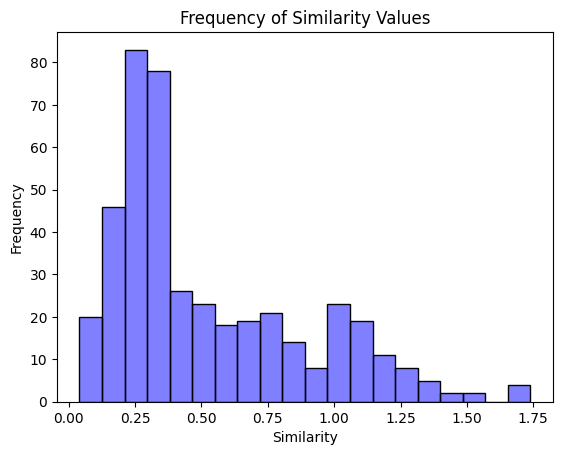

In [ ]:
flattened_sims = np.concatenate([arr.flatten() for arr in synthetic_sims])
sns.histplot(flattened_sims, bins=20, kde=False, color='blue', alpha=0.5)

plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Frequency of Similarity Values')

plt.show()

In [29]:
# plotting_true_spectra = [vec.detach().numpy() for vec in true_spectra]
# output_spectra = [vec.detach().numpy() for vec in synthetic_spectra]

# plot_results(plotting_true_spectra, output_spectra, chem_labels, idx=[0,3])

In [13]:
# save_specs = [[float(num.item()) for num in spec] for spec in [spec.detach() for spec in model_output]]

# df = pd.DataFrame(save_specs).T
# df.columns = output_labels
# df.head()
# df.to_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/artificial_spectra_vae_one_per_training_pt.csv', index=False)

In [28]:
# plotting_true_spectra = [vec.detach().numpy() for vec in true_spectra]
# plotting_input_spectra = [vec.detach().numpy() for vec in input_spectra]
# output_spectra = [vec.detach().numpy() for vec in model_output]

# plot_results_with_input(plotting_true_spectra, plotting_input_spectra, output_spectra, output_labels, idx=[0,3])

# Train Model:
---

In [62]:
model.eval()
test_output = []
test_true_spectra = []
test_output_labels = []
test_loss = 0

with torch.no_grad(): 
    for batch, labels in test_dataset:
        test_x_hat, test_mean, test_logvar = model(batch)

        loss = criterion(test_x_hat, batch, logvar, mean)
        test_loss+=loss

        chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
        for output_spectrum, true_spectrum, chem_name in zip(test_x_hat, batch, chem_names):
            test_output.append(output_spectrum)
            test_true_spectra.append(true_spectrum)
            test_output_labels.append(chem_name)

    average_loss = test_loss/len(test_dataset)
    print('Loss =', average_loss)

Loss = tensor(18.6312)


In [65]:
avg_cosine_sim = 0
avg_mse = 0

mse = nn.MSELoss()

for true_spec, synthetic_spec in zip(test_true_spectra, test_output):
  cos_sim = get_weighted_cosine_similarity(synthetic_spec, true_spec)
  avg_cosine_sim += cos_sim
  avg_mse += mse(synthetic_spec, true_spec)

avg_cosine_sim /= len(test_output)
avg_mse /= len(test_output)

print(avg_cosine_sim)
print(avg_mse)

tensor(0.2345)
tensor(18.9194)


In [66]:
average_sims = {}
# Calculate pairwise similarity between all spectra for each chemical
for chem in sorted_chem_names:
    chem_similarities = []
    if not chem == '(5R,11R)-5,11-Dimethylpentacosane':# and not chem == '1,3-Diaminopropane':
        chem_columns = list(spectra_df.filter(like=chem).columns)
        chem_subset = spectra_df[chem_columns][:915].T.values

        for i, j in combinations(range(len(chem_subset)), 2):
            similarity = get_weighted_cosine_similarity(chem_subset[i], chem_subset[j])
            chem_similarities.append(similarity.item())  
        
        average_sims[chem] = np.mean(chem_similarities)
    

In [67]:
synthetic_sims = []
for synthetic_spec, true_spec, chem in zip(test_output, test_true_spectra, test_output_labels):
    if not chem == '(5R,11R)-5,11-Dimethylpentacosane':
        sim = get_weighted_cosine_similarity(synthetic_spec, true_spec)
        sim_ratio = sim/average_sims[chem]
        synthetic_sims.append(sim_ratio.detach().numpy())

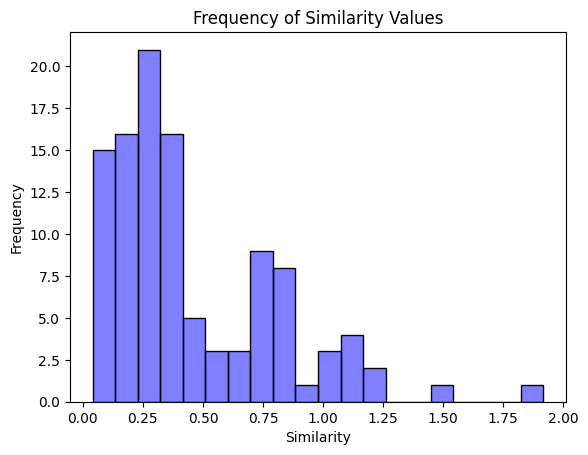

In [68]:
flattened_sims = np.concatenate([arr.flatten() for arr in synthetic_sims])
sns.histplot(flattened_sims, bins=20, kde=False, color='blue', alpha=0.5)

plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Frequency of Similarity Values')

plt.show()

In [70]:
num_above_pt_89 = 0
for sim in flattened_sims:
  if sim >= .9:
    num_above_pt_89 += 1
print(num_above_pt_89/len(flattened_sims))

0.1111111111111111


In [17]:
# plotting_true_spectra = [vec.detach().numpy() for vec in test_true_spectra]
# output_spectra = [vec.detach().numpy() for vec in test_output]

# plot_results(plotting_true_spectra, output_spectra, test_output_labels, idx=[0,3])

# Train Classifier:
---

In [59]:
num_spectra_per_real = 5

synthetic_spectra = []
synthetic_spectra_labels = []

model.eval()
with torch.no_grad():
    for batch, labels in train_dataset:
        x_hat, mean, logvar = model(batch)

        chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
        for output_spectrum, chem_name in zip(x_hat, chem_names):
            synthetic_spectra.append(output_spectrum)
            synthetic_spectra_labels.append(chem_name)

In [60]:
train_labels = [sorted_chem_names[list(encoding).index(1)] for encoding in train_chem_encodings] 
test_labels = [sorted_chem_names[list(encoding).index(1)] for encoding in test_chem_encodings]

# create random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)

# train and generate preds on only real spectra
rf_classifier.fit(x_train, train_labels)
preds = rf_classifier.predict(x_test)

# evaluate prediction accuracy
real_accuracy = accuracy_score(test_labels, preds)
print(f'Accuracy Score for real data: {round((100*real_accuracy))}%')

Accuracy Score for real data: 81%


In [61]:
spectra_preds_tensor = torch.stack(synthetic_spectra)
augmented_dataset = torch.cat((spectra_preds_tensor.clone().detach(), x_train))
augmented_dataset_labels = synthetic_spectra_labels + train_labels

# create random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)

# train and generate preds on augmented dataset
rf_classifier.fit(augmented_dataset, augmented_dataset_labels)
preds = rf_classifier.predict(x_test)

# evaluate prediction accuracy
real_accuracy = accuracy_score(test_labels, preds)
print(f'Accuracy Score for real and synthetic data: {round((100*real_accuracy))}%')

Accuracy Score for real and synthetic data: 83%


# Calculate ratio of predicted similarity to overall similarity:
---

Wei et. al, 2019 do this. Here's what they say about it: 

There is inherent noise in mass spectra due to stochasticity
of the underlying physical process and also to experimental
inconsistencies.9 The NIST replicates library provides multiple
spectra for each molecule, and we can use these sets of spectra
to characterize the scale of this noise for each molecule.
Specifically, we define the inherent noise for a given molecule
as the average pairwise similarity between all corresponding
spectra, in both the NIST main library and the NIST replicates
library, and refer to this as the overall similarity.
For each molecule, we compute the ratio of the predicted
similarity to overall similarity as a normalized metric for the
quality of our predictions. A ratio of 1.0 would suggest that
there are is limited available headroom for improvements using
machine learning, since the model’s errors are comparable to
the variability in the data.

In [22]:
# synthetic_sims = []
# for synthetic_spec, true_spec, chem in zip(model_output, true_spectra, output_labels):
#     if not chem == '(5R,11R)-5,11-Dimethylpentacosane':
#         sim = get_weighted_cosine_similarity(synthetic_spec, true_spec)
#         sim_ratio = sim/average_sims[chem]
#         synthetic_sims.append(sim_ratio.detach().numpy())

In [21]:
average_sims = {}
# Calculate pairwise similarity between all spectra for each chemical
for chem in sorted_chem_names:
    chem_similarities = []
    if not chem == '(5R,11R)-5,11-Dimethylpentacosane':# and not chem == '1,3-Diaminopropane':
        chem_columns = list(spectra_df.filter(like=chem).columns)
        chem_subset = spectra_df[chem_columns][:915].T.values

        for i, j in combinations(range(len(chem_subset)), 2):
            similarity = get_weighted_cosine_similarity(chem_subset[i], chem_subset[j])
            chem_similarities.append(similarity.item())  
        
        average_sims[chem] = np.mean(chem_similarities)
    

In [28]:
model.eval()
synthetic_spectra = []
chem_labels = []
train_true_spectra = []

with torch.no_grad(): 
    for batch, labels in train_dataset:
        x_hat, mean, logvar = model(batch)

        chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
        for output_spectrum, true_spectrum, chem_name in zip(x_hat, batch, chem_names):
            if not chem == '(5R,11R)-5,11-Dimethylpentacosane':
                synthetic_spectra.append(output_spectrum)
                train_true_spectra.append(true_spectrum)
                chem_labels.append(chem_name)

thing = pd.DataFrame(synthetic_spectra)

In [29]:
synthetic_sims = []
for synthetic_spec, true_spec, chem in zip(synthetic_spectra, train_true_spectra, chem_labels):
    # if not chem == '(5R,11R)-5,11-Dimethylpentacosane':
    sim = get_weighted_cosine_similarity(synthetic_spec, true_spec)
    sim_ratio = sim/average_sims[chem]
    synthetic_sims.append(sim_ratio.detach().numpy())

In [25]:
# average_synthetic_sims = {}

# output_df = pd.DataFrame(model_output)

# # Calculate pairwise similarity between all synthetic spectra for each chemical
# for i, synthetic_spec, chem in enumerate(zip(model_output, output_labels)):
#     chem_similarities = []
#     if not chem == '(5R,11R)-5,11-Dimethylpentacosane':# and not chem == '1,3-Diaminopropane':
#         # only want to compare spectra 
#         if chem == output_labels[i+1]: 
        
#         average_snthetic_sims[chem] = np.mean(chem_similarities)

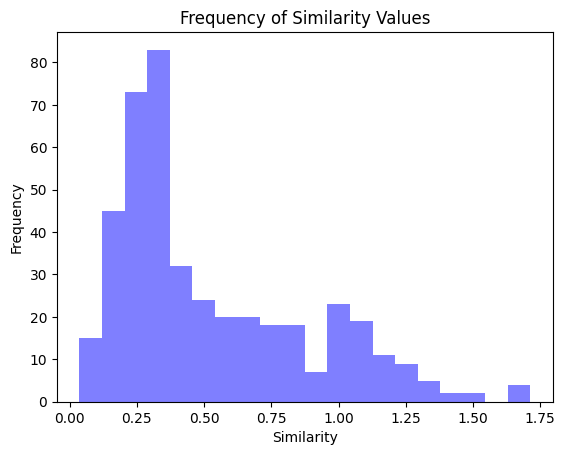

In [33]:
plt.hist(synthetic_sims, bins=20, alpha=0.5, color='blue')

plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Frequency of Similarity Values')

plt.show()

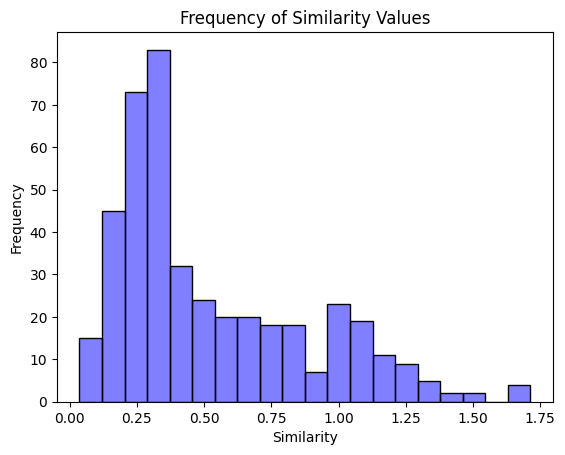

In [39]:
flattened_sims = np.concatenate([arr.flatten() for arr in synthetic_sims])
sns.histplot(flattened_sims, bins=20, kde=False, color='blue', alpha=0.5)

# Set the labels and title
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Frequency of Similarity Values')

# Show the plot
plt.show()

In [158]:
chem_similarities = {}
for chem in sorted_chem_names:
    # create a subset dataset of just one chemical
    chem_columns = list(spectra_df.filter(like=chem).columns)

    chem_similarities[chem] = {}

    for col in spectra_df[chem_columns]:
        chem_similarities[chem][col] = []
        # print(col)
        # print('----------------')
        chem_columns.remove(col)    

        sims_list = []
        for col2 in chem_columns:
            # print(col2)
            chem_similarities[chem][col].append(get_weighted_cosine_similarity(torch.tensor(spectra_df[col]), torch.tensor(spectra_df[col2])).item())
        
        # chem_similarities[chem][col] = sims_list
        # print('--------------------')
        # print(col)
        # chem_similarities[col].append(sims_list)
        # print(len(sims_list))
    break

len(chem_similarities['(5R,11R)-5,11-Dimethylpentacosane']['(5R,11R)-5,11-Dimethylpentacosane.1'])
# len(list(spectra_df.filter(like='(5R,11R)-5,11-Dimethylpentacosane').columns))

32